In [1]:
import sys
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import datetime
from tqdm import tqdm
import GPy
from collections import defaultdict
from pathlib import Path
import seaborn as sns
import scipy.stats as stats
from matplotlib.colors import ListedColormap
import warnings
import time
from itertools import product
from joblib import Parallel, delayed
from operator import itemgetter
import sncosmo
import emcee
import corner
import pickle
from multiprocessing import Pool

mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.autolayout'] = True
# mpl.rcParams['figure.dpi'] = 300
# mpl.rcParams['axes.spines.right'] = False
# mpl.rcParams['axes.spines.top'] = False


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})


def utkarshGrid():
    plt.minorticks_on()
    plt.grid(color='grey',
             which='minor',
             linestyle=":",
             linewidth='0.1',
             )
    plt.grid(color='black',
             which='major',
             linestyle=":",
             linewidth='0.1',
             )
    
# set random number seed to ensure reproducibility
seed = 3
rstate = np.random.RandomState(seed)

path = os.path.dirname(os.getcwd())
os.chdir(path)
from Emulator.Classes.AllData import AllData
from Emulator.Classes.LightCurve import utkarshGrid, LightCurve
from Emulator.Classes.GP import GP
from Emulator.Classes.GP2D import GP2D
from Emulator.Classes.GP5D import GP5D
from Emulator.Classes.Inference import Inference
os.chdir(os.getcwd() + "/Emulator")
os.getcwd()

'/Users/utkarsh/PycharmProjects/KilonovaeLightCurves/Emulator'

In [2]:
gp = GP5D("Classes/reference.csv")
gp.delete_folder_files("data/pcaComponents")
gp.delete_folder_files("data/pcaComponentsTrained")
gp.delete_folder_files("data/pcaComponentsTrainedError")
gp.delete_folder_files("data/pcaTrained")
gp.delete_folder_files("data/pcaTrainedUpper")
gp.delete_folder_files("data/pcaTrainedLower")

In [3]:
inference = Inference()
inference.truth_arr = np.array([0.001, 0.05, 45, 6])
inference.train_fluxes()

Training Time: 50s


In [4]:
inference.truth_arr_normed = inference.normalization_helper(inference.truth_arr)
mejdyn = inference.truth_arr_normed[0]
mejwind = inference.truth_arr_normed[1]
phi = inference.truth_arr_normed[2]
iobs = inference.truth_arr_normed[3]

In [5]:
def predict_fluxes(self, mejdyn, mejwind, phi, iobs, extra_item=None):
    theta = np.array([mejdyn, mejwind, phi, iobs])
    mejdyn, mejwind, phi, iobs = list(self.undo_normalization_helper(theta))
    gp = self.gp
    gp.validationX = [mejdyn, mejwind, phi, iobs]
    gp.validationXNormed = self.normalization_helper(np.array(gp.validationX))
    gp.model_predict_cross_validation(include_like=True, messages=False)  # Save cross validation
    gp.save_trained_data(errors=False, theta=(mejdyn, mejwind, phi, iobs), extra_item=extra_item)
    y = np.load(f"data/pcaTrained/mejdyn{mejdyn}_mejwind{mejwind}_phi{phi}_iobs{iobs}.npy")
    os.remove(f"data/pcaComponentsTrained/mejdyn{mejdyn}_mejwind{mejwind}_phi{phi}_iobs{iobs}.npy")
    os.remove(f"data/pcaComponentsTrainedError/mejdyn{mejdyn}_mejwind{mejwind}_phi{phi}_iobs{iobs}.npy")
    filters = ["sdss::u", "sdss::g", "sdss::r", "sdss::i", "sdss::z",
               "swope2::y", "swope2::J", "swope2::H"]

    m_complete = []
    t = gp._t_helper()
    for i in range(len(filters)):
        source = sncosmo.TimeSeriesSource(t, gp.wv_range * 10, 10 ** y)
        m = source.bandmag(filters[i], "ab", t)
        m_complete.append(m)

    y_mag = np.array(m_complete, dtype=float).T
    t_matrix = np.repeat(t, len(filters)).reshape(len(t), len(filters))
    x = t_matrix
    self.filters = filters
    return x, y_mag

In [6]:
x_true, y_true = predict_fluxes(inference, mejdyn, mejwind, phi, iobs)
err_percent = 1e-2

In [7]:
def loglike(theta, x, y, yerr):
    mejdyn, mejwind, phi, iobs = theta
    x, y_model = predict_fluxes(inference, mejdyn, mejwind, phi, iobs)
    logl = - 0.5 * np.sum(((y - y_model) / yerr) ** 2)
    return logl

In [8]:
theta_original = np.copy(inference.truth_arr_normed)
log = []
iobs_list = inference.normalize_iobs(np.arange(0, 11, 0.1))
for iobs in tqdm(iobs_list):
    theta = [theta_original[0], theta_original[1], theta_original[2], iobs]
    logl = loglike(theta, None, y_true, err_percent*y_true)
    log.append(logl)

100%|██████████| 110/110 [00:05<00:00, 20.89it/s]


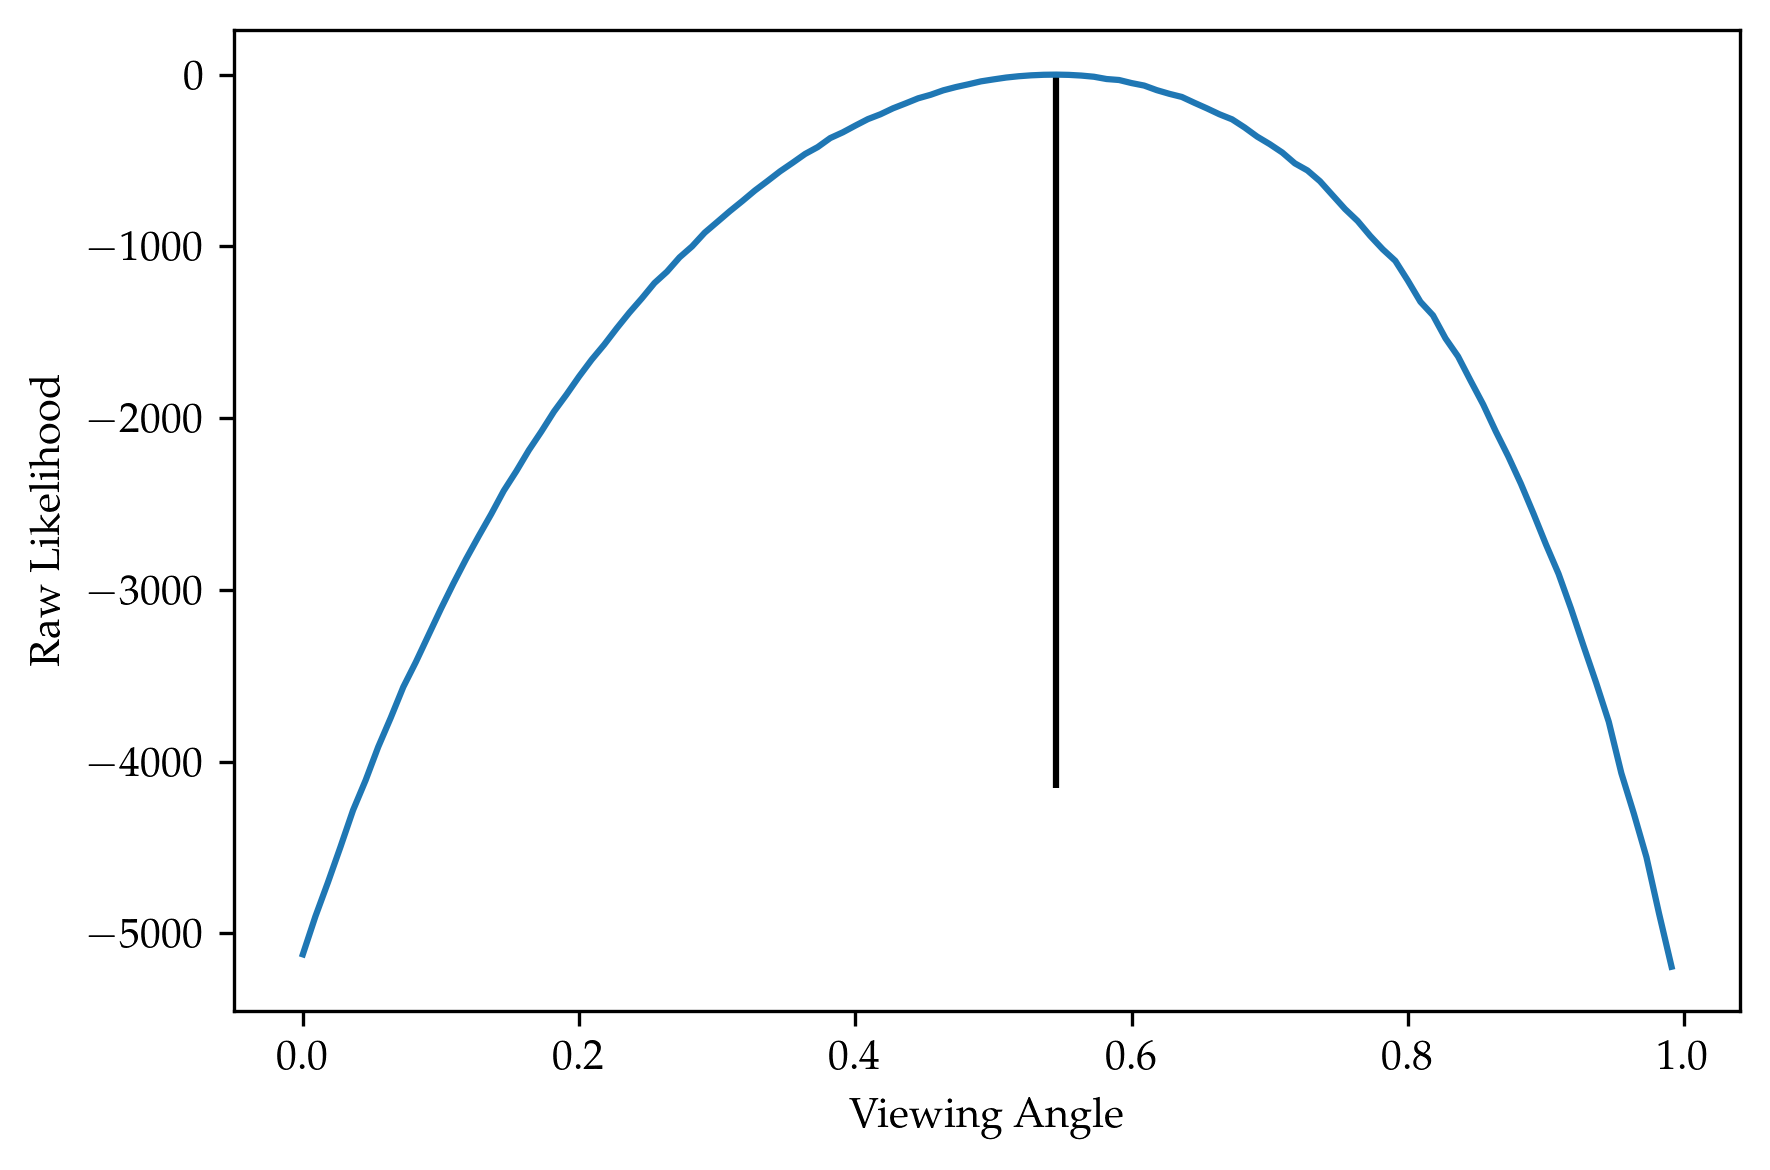

In [9]:
plt.figure(dpi = 300, figsize = (6,4))
plt.plot(iobs_list, log)
plt.vlines(x = inference.truth_arr_normed[3], ymin = min(log)*0.8, ymax = max(log), color = "black")
plt.xlabel("Viewing Angle")
plt.ylabel("Raw Likelihood")
plt.show()

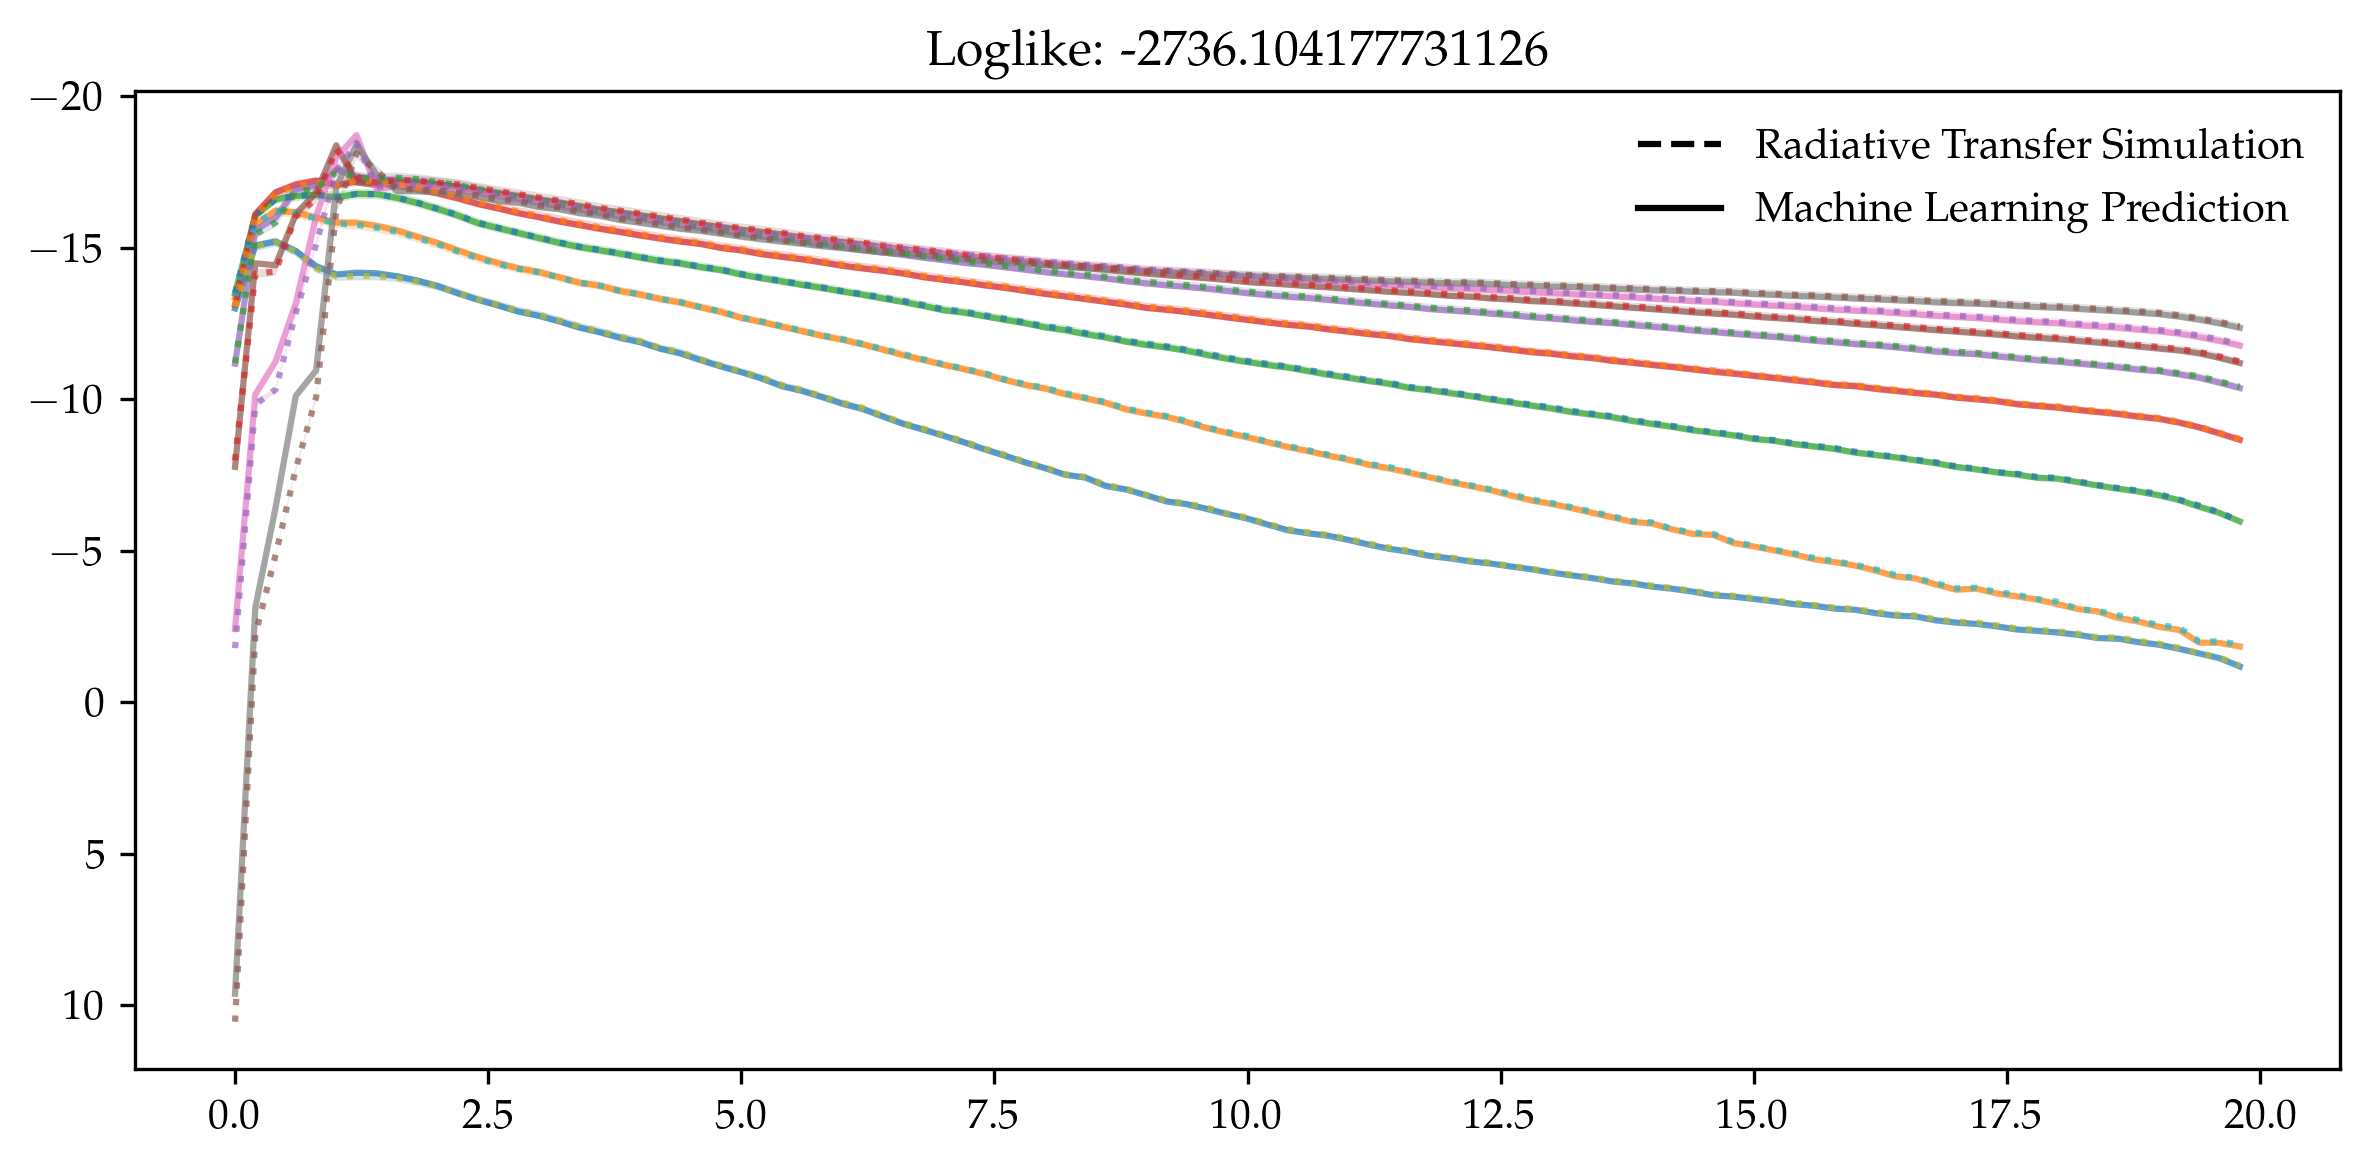

In [10]:
theta = [theta_original[0], theta_original[1], theta_original[2], iobs_list[int(len(iobs_list)*0.9)]]
mejdyn, mejwind, phi, iobs = theta
x, y_model = predict_fluxes(inference, mejdyn, mejwind, phi, iobs)
y = y_true
yerr = err_percent*y
logl = - 0.5 * np.sum(((y - y_model) / yerr) ** 2)

plt.figure(dpi = 300, figsize = (8,4))
plt.title(f"Loglike: {logl}")
plt.plot(x, y_model, alpha = 0.7)
plt.plot(x, y, alpha = 0.7, linestyle = "dotted")

for j in range(len(x.T)):
    plt.fill_between(x.T[j], y1 = y.T[j]+yerr.T[j], y2=y.T[j]-yerr.T[j], alpha = 0.2)
    
plt.gca().invert_yaxis()
plt.plot(x[0], np.ones(x[0].shape), linestyle = "dashed", color = "black", label = "Radiative Transfer Simulation", alpha = 1)
plt.plot(x[0], np.ones(x[0].shape), linestyle = "solid", color = "black", label = "Machine Learning Prediction", alpha = 1)
plt.legend()
plt.show()

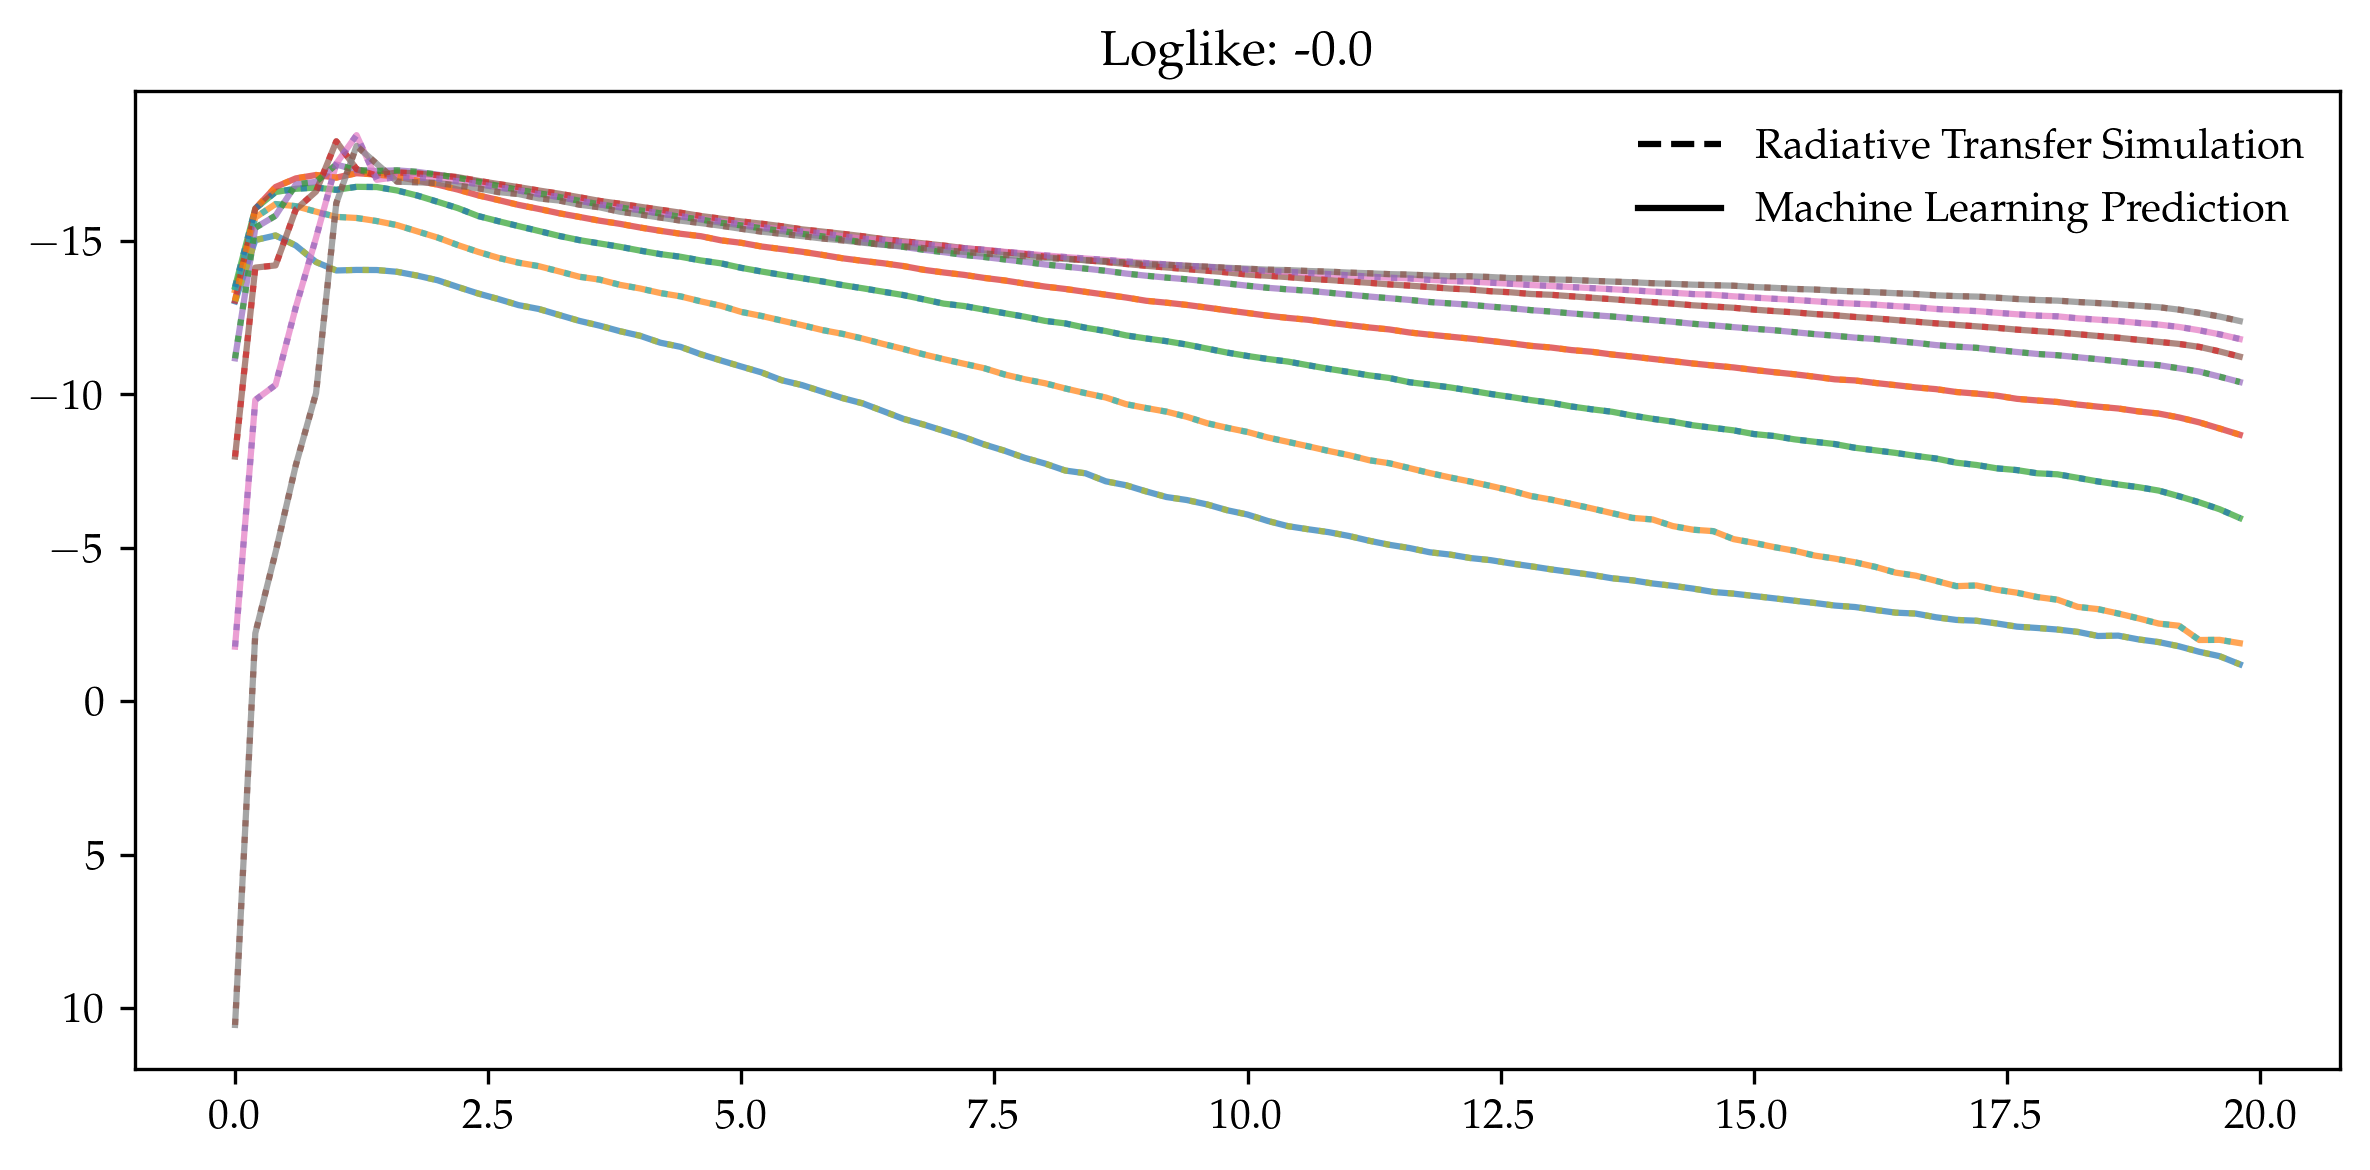

In [11]:
theta = [theta_original[0], theta_original[1], theta_original[2], theta_original[3]]
mejdyn, mejwind, phi, iobs = theta
x, y_model = predict_fluxes(inference, mejdyn, mejwind, phi, iobs)
y = y_true
yerr = err_percent*y
logl = - 0.5 * np.sum(((y - y_model) / yerr) ** 2)

plt.figure(dpi = 300, figsize = (8,4))
plt.title(f"Loglike: {logl}")
plt.plot(x, y_model, alpha = 0.7)
plt.plot(x, y, alpha = 0.7, linestyle = "dotted")
plt.gca().invert_yaxis()
plt.plot(x[0], np.ones(x[0].shape), linestyle = "dashed", color = "black", label = "Radiative Transfer Simulation", alpha = 1)
plt.plot(x[0], np.ones(x[0].shape), linestyle = "solid", color = "black", label = "Machine Learning Prediction", alpha = 1)
plt.legend()
plt.show()